# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 7.5

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [422]:
!pip install folium

In [423]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [425]:
!wget -O 'train_2.csv' -q 'https://www.dropbox.com/scl/fi/lrjb27c9zfyoriwrttwtx/train.csv?rlkey=gbc30vwisb476j7iozhvungjm&dl=0'

In [429]:
df = pd.read_csv('train_2.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [430]:
df = df.drop(columns="dropoff_datetime")
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [431]:
%config InlineBackend.figure_format = 'retina' #настройки для графиков из первого дз
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12

Text(0.5, 1.0, 'Распределение trip_duration')

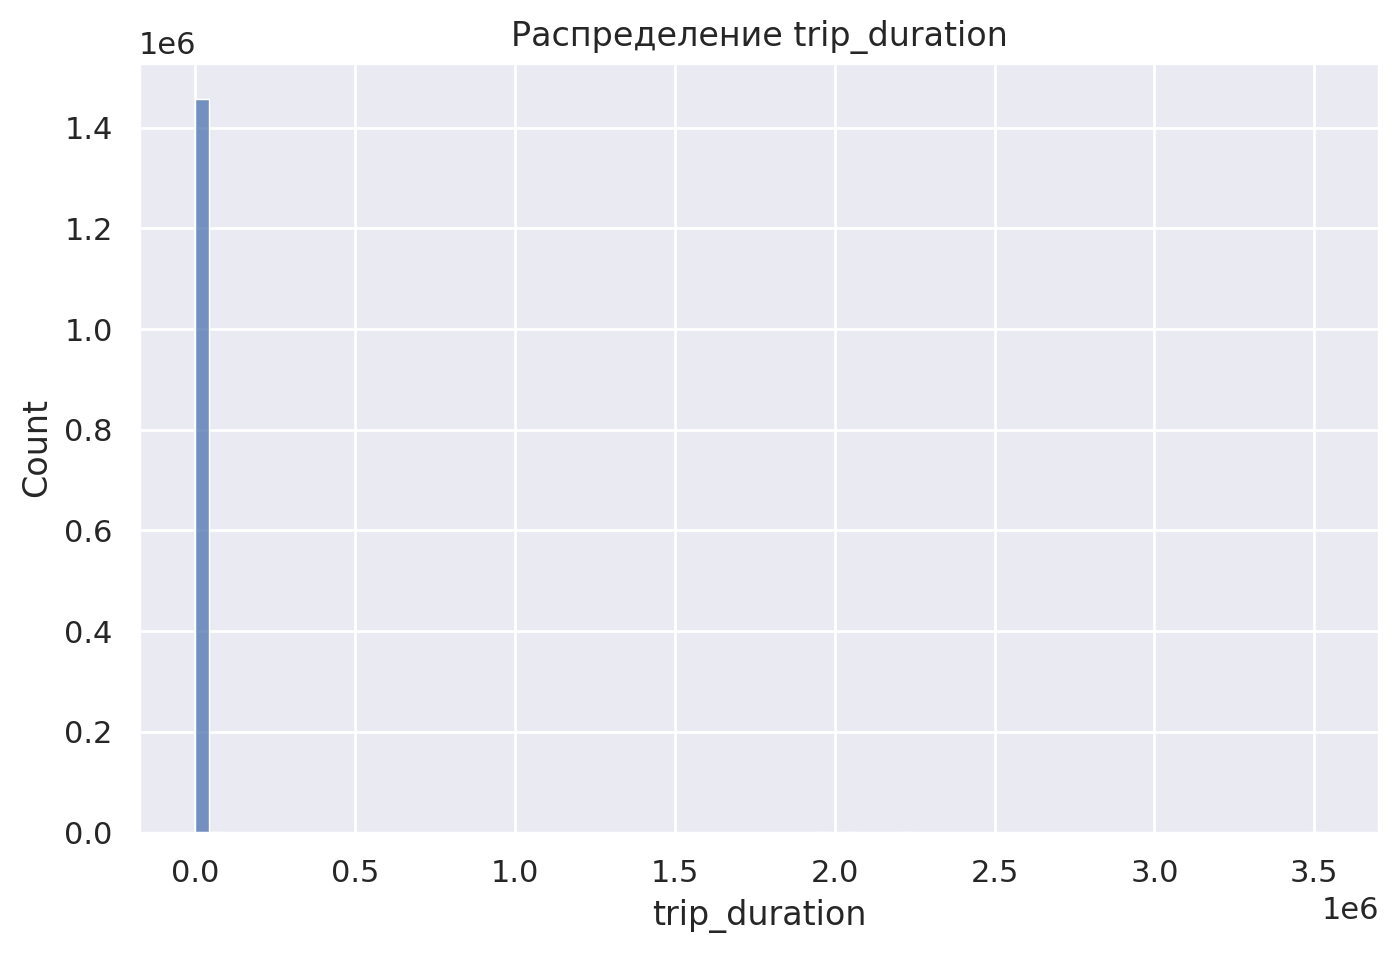

In [432]:
sns.histplot(df['trip_duration'], bins=80)
plt.title('Распределение trip_duration')

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В данных есть "выбросы", слишком большие значения по сравнению со средними, из-за чего график получился плохим.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

RMSLE более устойчива к выбросам, чем RMSE.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: \
Подставим в RMSLE: $a(x_i) = \exp(\hat{a}(x_i)) - 1$: \
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2}$$
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \hat{a}(x_i)\big)^2}$$
Теперь посчитаем MSE, при условии $\hat{y}_i = \log{(y_i + 1)}$:
$$\text{MSE}(X, \hat{y}, \hat{a}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big((\log{(y_i + 1)}) - \hat{a}(x_i)\big)^2$$
Как можно увидеть, в данном случае метрики качетсва MSE и RMSLE эквивалентны c точки зрения оптимизации \
\
Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [433]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
save_for_7_task = df['trip_duration']
df = df.drop(columns="trip_duration")

Text(0.5, 1.0, 'Распределение log_trip_duration')

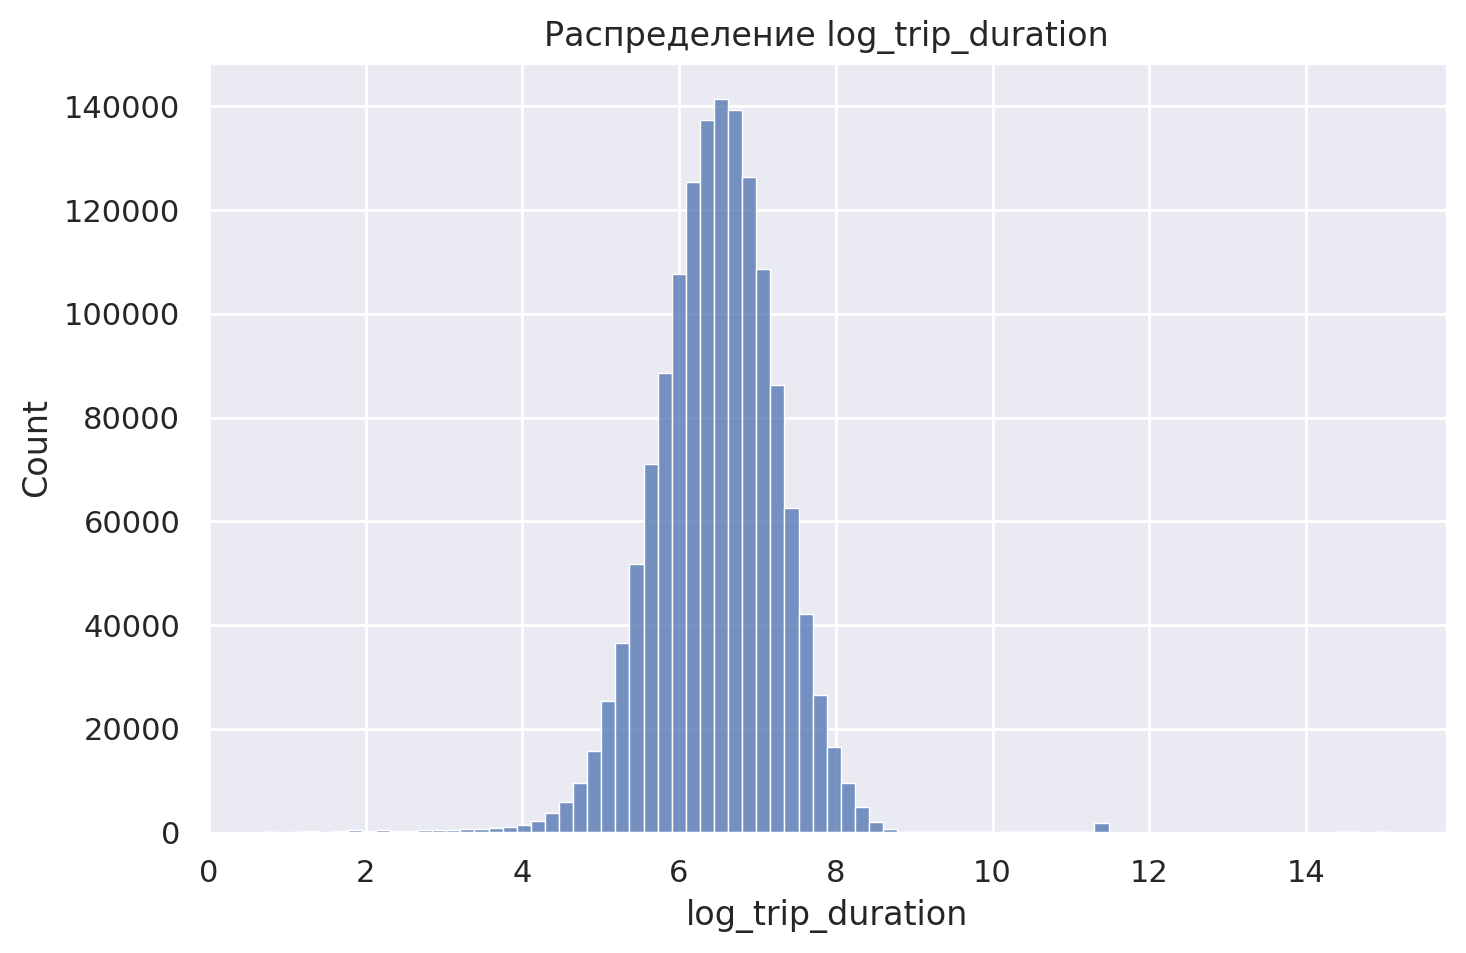

In [434]:
sns.histplot(df['log_trip_duration'], bins=80)
plt.title('Распределение log_trip_duration')

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [435]:
def rmsle(log1p_y_true, log1p_y_pred):
    er = np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))
    return er

rmsle_best_const = rmsle(df['log_trip_duration'], np.mean(df['log_trip_duration']))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

Text(0.5, 1.0, 'Зависимость количетсва поездок от даты')

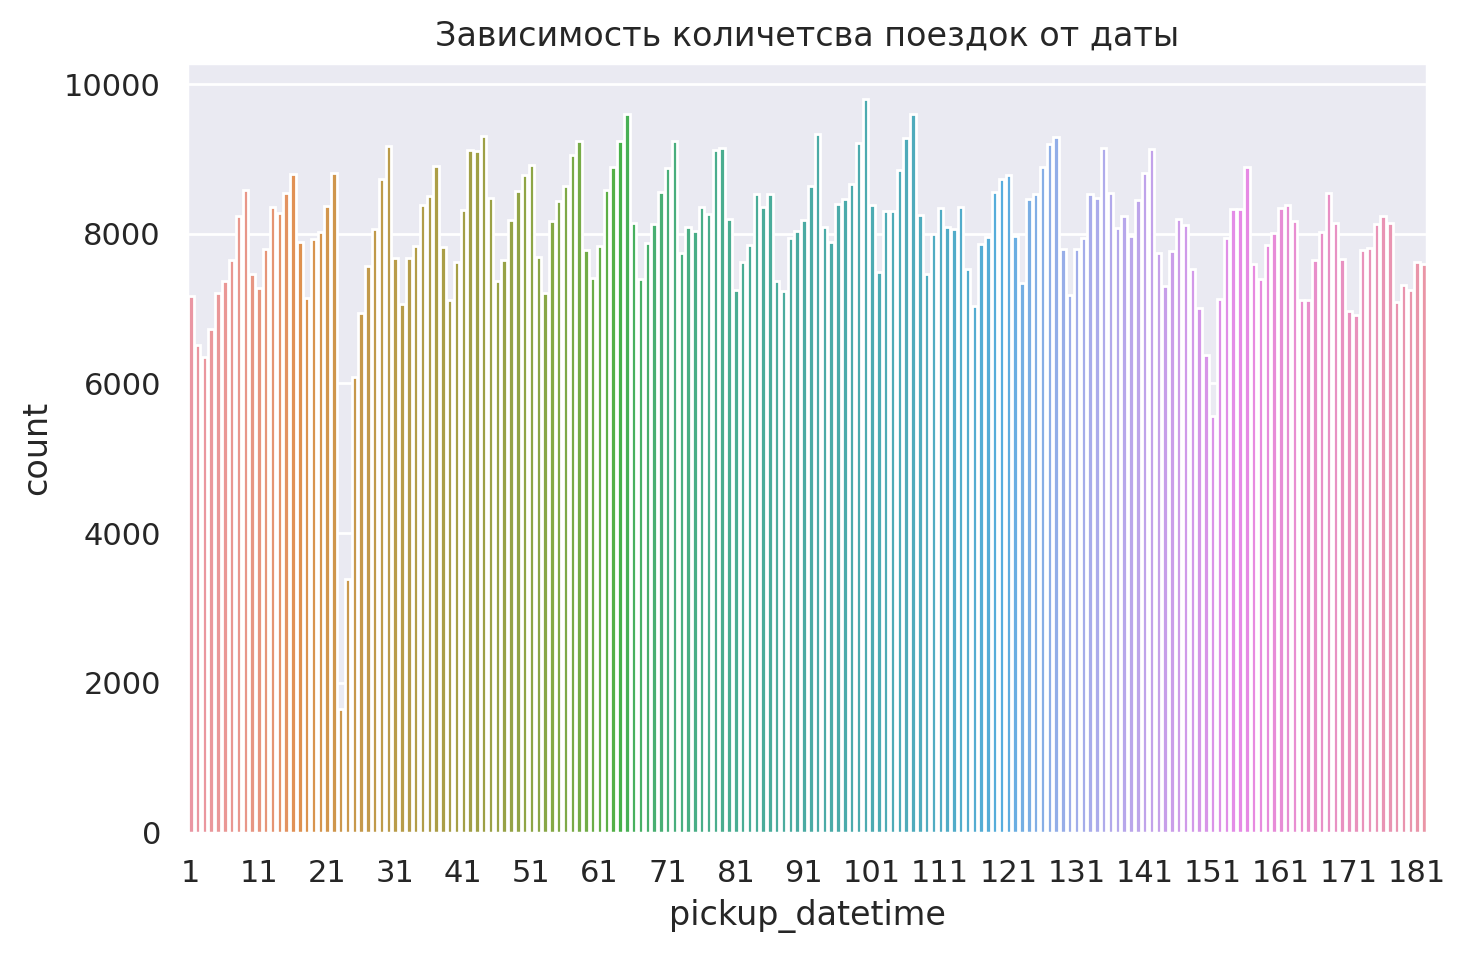

In [436]:
df_sort = df.sort_values('pickup_datetime')
sns.countplot(x=df_sort['pickup_datetime'].dt.day_of_year, data=df_sort)
count_days = len((df_sort['pickup_datetime'].dt.day_of_year).unique())
plt.xticks(np.arange(0, count_days, 10))
plt.title('Зависимость количетсва поездок от даты')

Найдем количетсво заказов такси в каждый из дней:

In [437]:
df['date'] = df['pickup_datetime'].dt.date
x = df.groupby(['date']).count()
y = x.sort_values('id', ascending=True)['id']
df = df.drop(columns='date')
print(y)

date
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
              ... 
2016-02-13    9309
2016-04-02    9325
2016-03-05    9597
2016-04-16    9602
2016-04-09    9796
Name: id, Length: 182, dtype: int64


как можно заметить 2016-01-23, 2016-01-24, 2016-05-30 заказов было гораздо меньше, чем в другие дни \
23-го и 24-го января 2016 в Нью-Йорке была снежная буря, из-за который запретили автомобильное движение \
30-го мая 2016 в аэропорту Нью-Йорка был крупный сбой компьютеров, из-за которого образовались огромные очереди.

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

ответ выше

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

Text(0.5, 1.0, 'Зависимость количетсва поездок от часа в сутках')

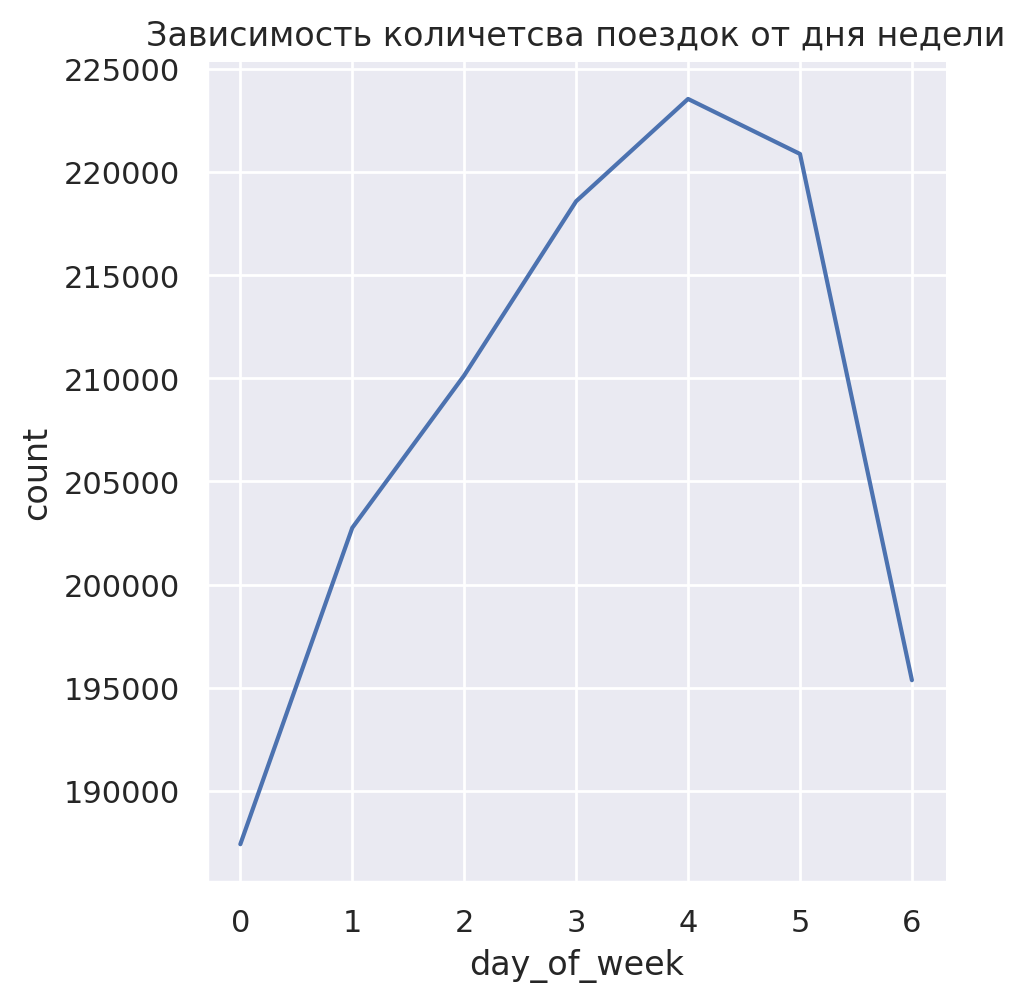

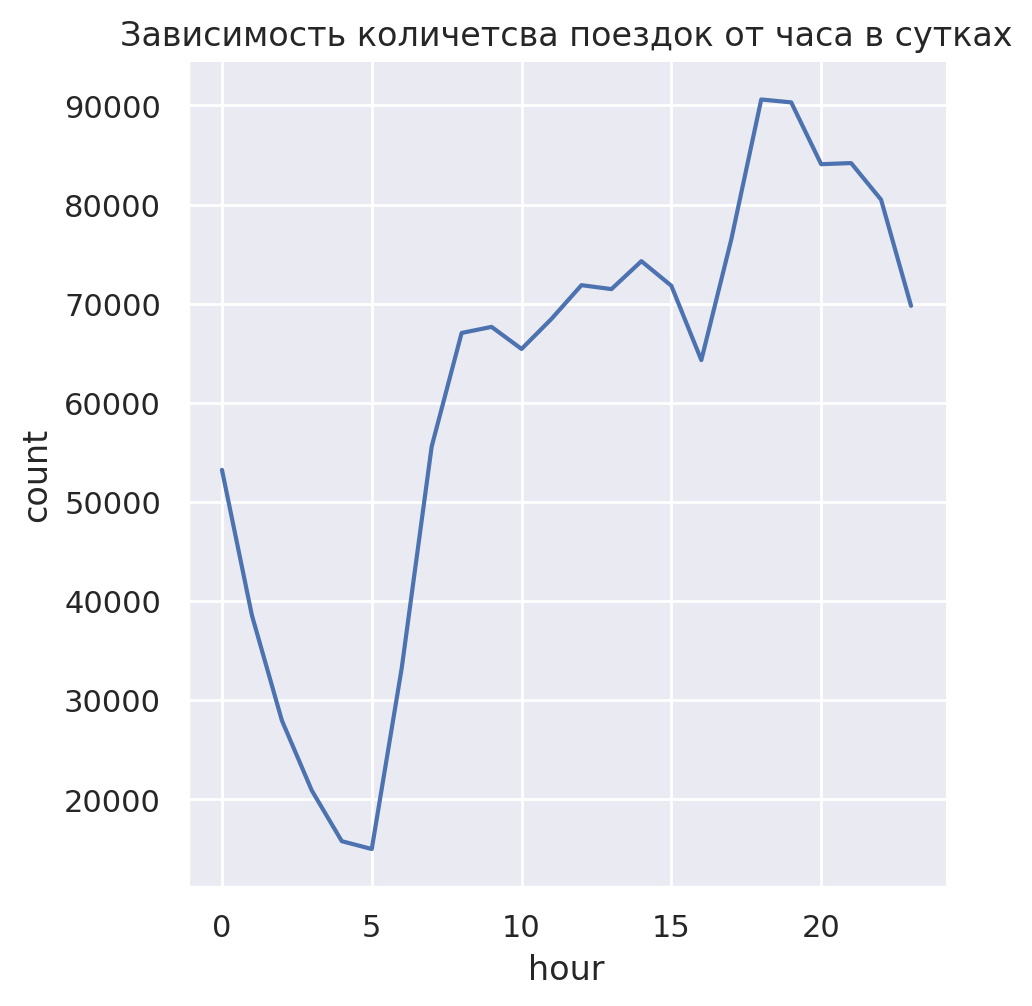

In [438]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
df['hour'] = df['pickup_datetime'].dt.hour
xtmp = df.groupby('day_of_week').count()['id']
plot_day = xtmp.to_frame()
plot_day = plot_day.sort_values('day_of_week')
ytmp = df.groupby('hour').count()['id']
plot_hour = ytmp.to_frame()
plot_day = plot_day.rename(columns={'id': 'count'})
plot_hour = plot_hour.rename(columns={'id': 'count'})

sns.relplot(data=plot_day, x='day_of_week', y='count', kind='line')
plt.title("Зависимость количетсва поездок от дня недели")
sns.relplot(data=plot_hour, x='hour', y='count', kind='line')
plt.title("Зависимость количетсва поездок от часа в сутках")

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Text(0.5, 1.0, 'Зависимость количетсва поездок от часа в сутках (дни)')

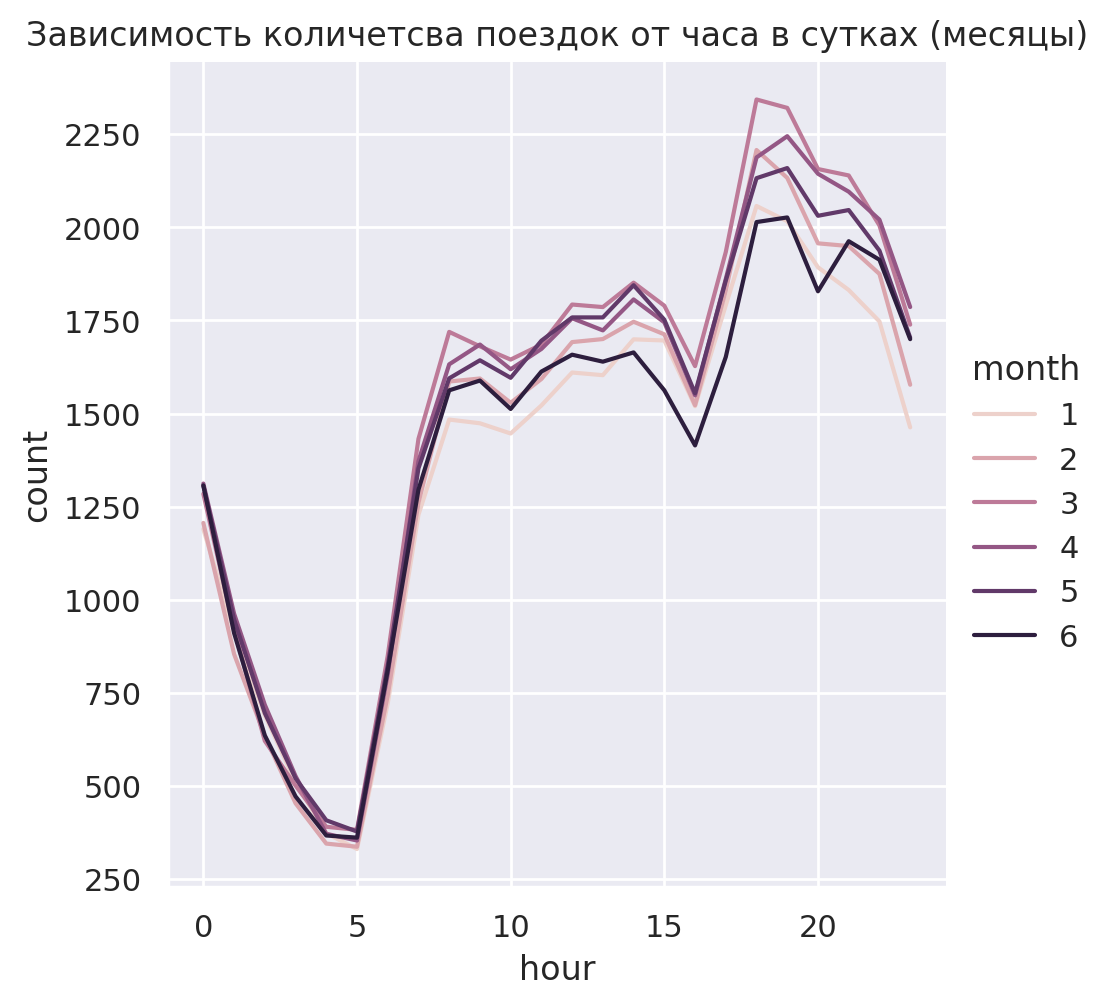

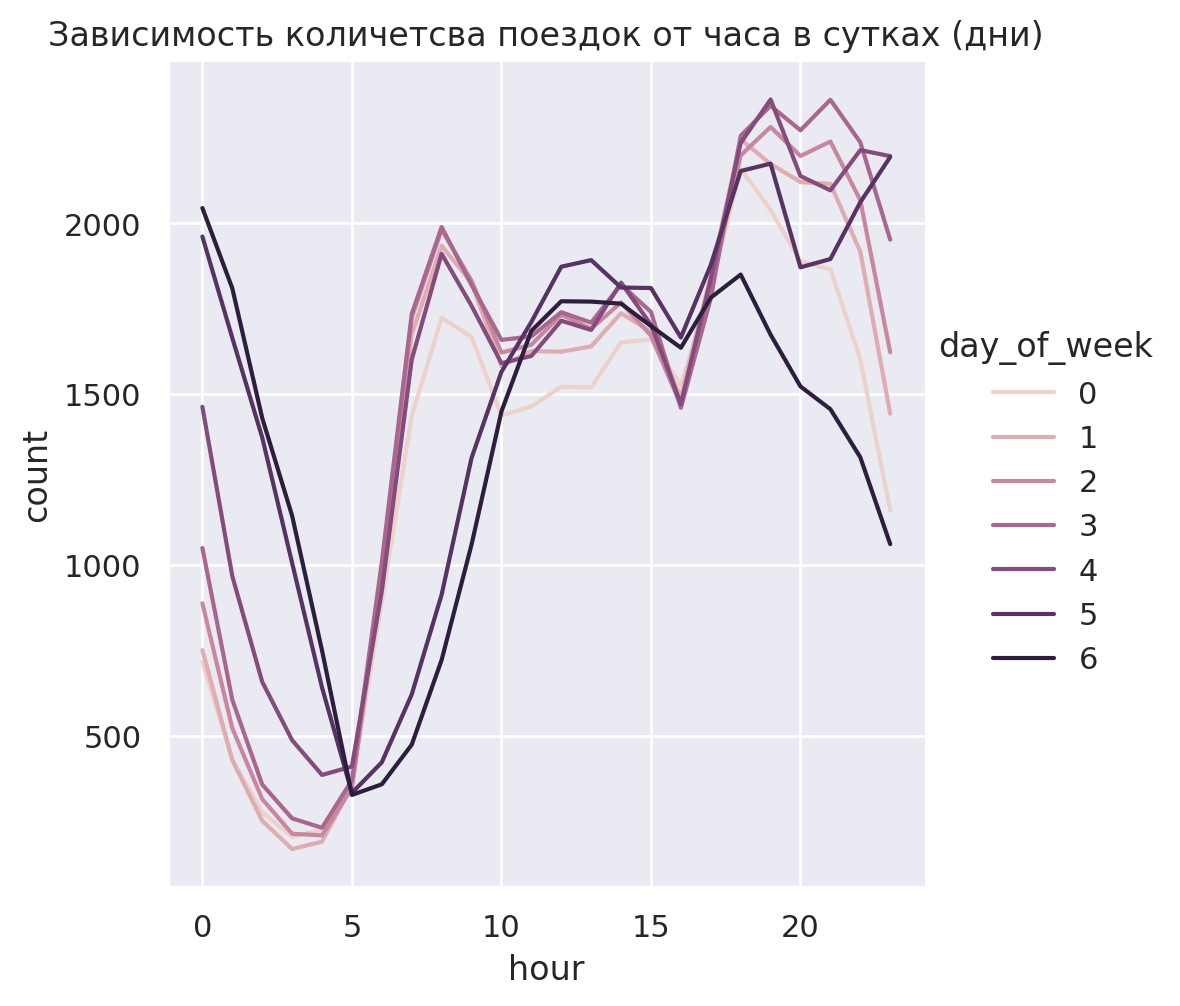

In [439]:
df['month'] = df['pickup_datetime'].dt.month
xtmp = df.groupby(['hour', 'month', 'day_of_week']).count()['id']
df3 = xtmp.to_frame()
df3.rename(columns={'id': 'count'}, inplace=True)

sns.relplot(data=df3, x='hour', y='count', hue='month', kind='line', errorbar=None)
plt.title("Зависимость количетсва поездок от часа в сутках (месяцы)")
sns.relplot(data=df3, x='hour', y='count', hue='day_of_week', kind='line', errorbar=None)
plt.title("Зависимость количетсва поездок от часа в сутках (дни)")

In [440]:
df = df.drop(columns=["day_of_week", "hour", "month"])

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Выделяется время: 5 утра. Это может быть связано с тем, что в это время большинство людей спят. Также выделяется 19, 20 часов вечера. Вероятно, в это время все едут домой с работы. В разные месяцы более-менее одинаково распределенно количетсво заказов. В выходные дни видно, что много такси заказывают ночью (0:00, 1:00) и меньше заказывают в 19, 20 вечера. Наоборот происходит в будние дни. Это может быть связано с тем, что в выходные люди отдыхают от работы и поздно возвращаются домой

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Text(0.5, 1.0, 'Зависимость среднего log_trip_duration от дня в году')

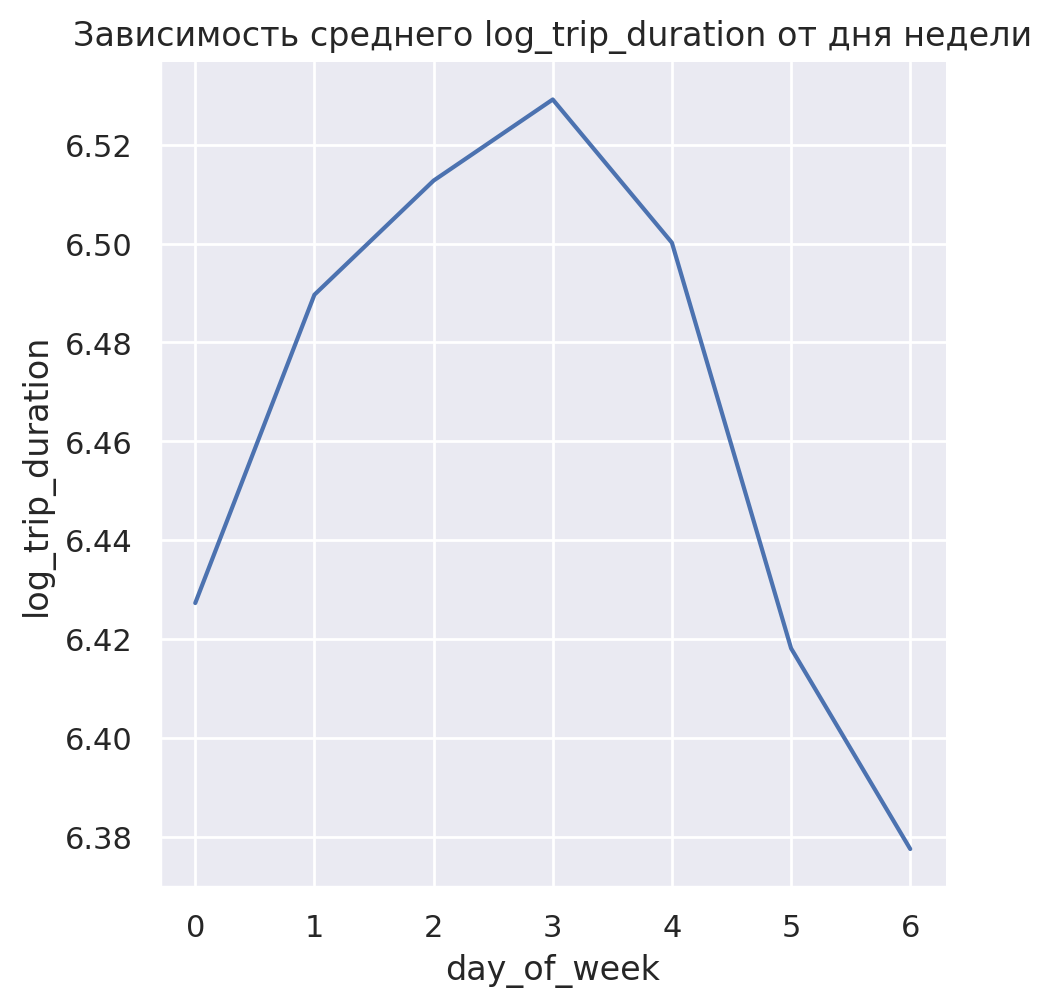

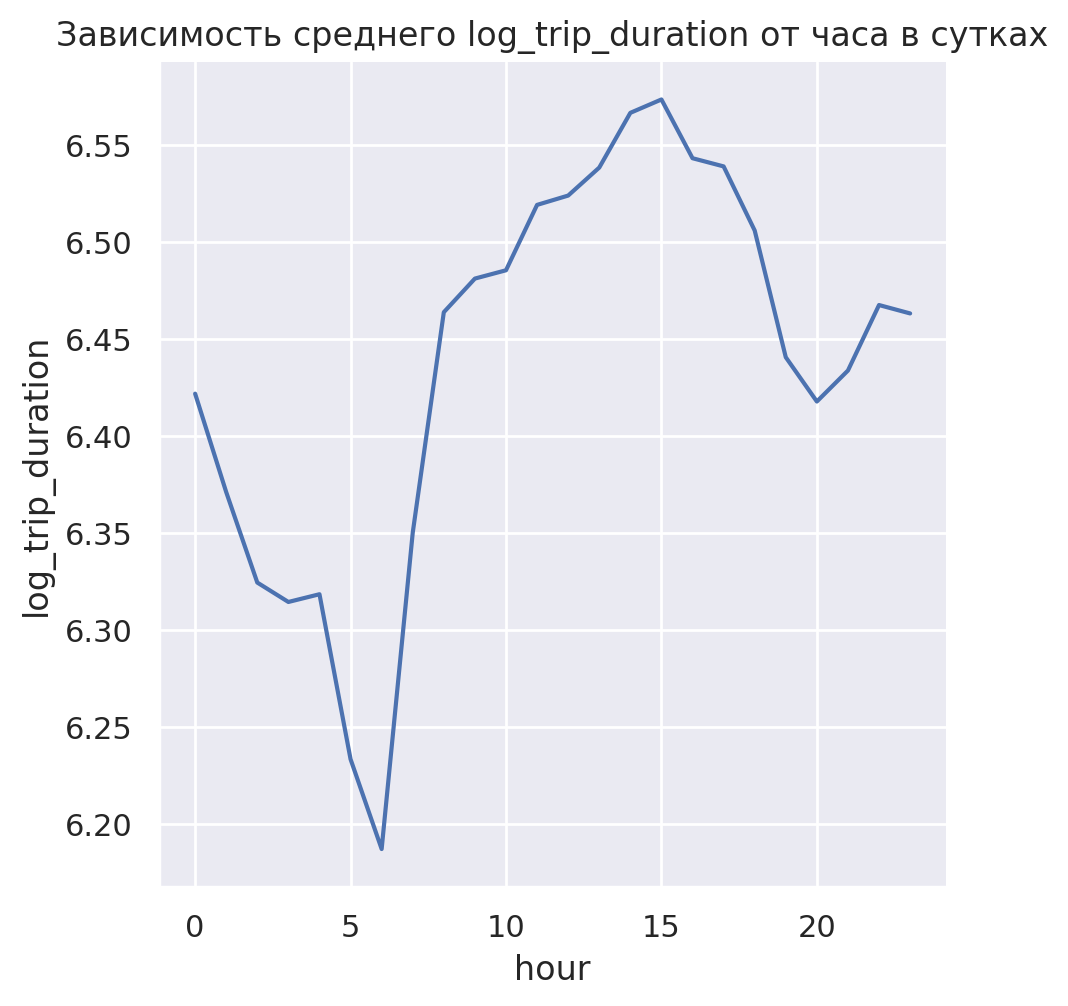

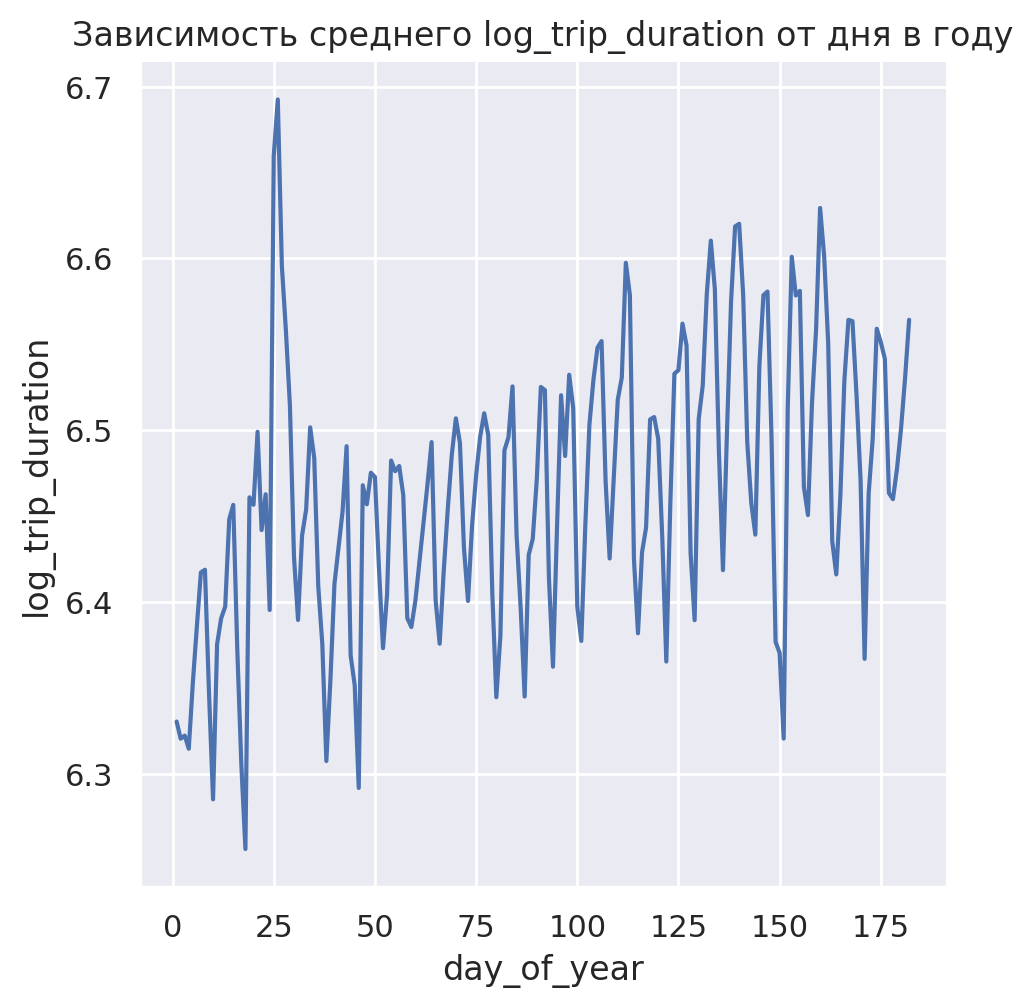

In [441]:
from sklearn.model_selection import train_test_split

y = df['log_trip_duration']
x = df.drop(columns=['log_trip_duration'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
x_frame_plot = pd.DataFrame()
x_frame_plot['day_of_week'] = x_train['pickup_datetime'].dt.day_of_week
x_frame_plot['hour'] = x_train['pickup_datetime'].dt.hour
x_frame_plot['day_of_year'] = x_train['pickup_datetime'].dt.day_of_year
x_frame_plot['log_trip_duration'] = y_train
plot_4 = x_frame_plot.groupby(['day_of_week']).mean()['log_trip_duration']
plot_4_f = plot_4.to_frame()
sns.relplot(data=plot_4_f, x='day_of_week', y='log_trip_duration', kind='line')
plt.title("Зависимость среднего log_trip_duration от дня недели")
plot_4_2 = x_frame_plot.groupby(['hour']).mean()['log_trip_duration']
plot_4_2_f = plot_4_2.to_frame()
sns.relplot(data=plot_4_2_f, x='hour', y='log_trip_duration', kind='line')
plt.title("Зависимость среднего log_trip_duration от часа в сутках")
plot_4_3 = x_frame_plot.groupby(['day_of_year']).mean()['log_trip_duration']
plot_4_3_f = plot_4_3.to_frame()
sns.relplot(data=plot_4_3_f, x='day_of_year', y='log_trip_duration', kind='line')
plt.title("Зависимость среднего log_trip_duration от дня в году")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Да, похожи. Вероятно, поездки совершаются довольно регулярно и для каждого времени есть наиболее популярные места, куда можно поехать. \
В первый аномальный период видно значительное увеличение длины поездки, а во второй наоборот уменьшение. \
Да, видно, что функция растет.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [442]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour
df['is_abnormal_1'] = 1 * ((df['pickup_datetime'].dt.strftime("%d%m%Y") == "23012016") | (df['pickup_datetime'].dt.strftime("%d%m%Y") == "24012016"))
df['is_abnormal_2'] = 1 * (df['pickup_datetime'].dt.strftime("%d%m%Y") == "30052016")
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

 day_of_week - категориальный признак. Он имеет всего 7 значений. Тем более, если их записать в виде (Monday, ...), то он вообще не принадлежит R \
 month - категориальный признак. Всего 12 значений. Тем более, если их записать в виде (January, ...), то он вообще не принадлежит R\
 hour - категориальный признак. Тут спорный момент, но количетсво значений также очень ограничено, поэтому не могу отнести его к числовым \
 is_abnormal_1(2) - категориальный признак. Имеет всего 2 значения. \
 day_of_year - числовой признак. Ситуации как и в hour, но тут значений ощутимо больше (365, 366). Также на графике для day_of_year наблюдается линейная зависимость. Поэтому отнесу его к числовым. \

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [443]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

#часть кода взята из 2-го семинара

df_for_ridge = df[['log_trip_duration', 'day_of_week', 'month', 'hour', 'is_abnormal_1', 'is_abnormal_2', 'day_of_year']]

y = df_for_ridge['log_trip_duration']
x = df_for_ridge.drop(columns=['log_trip_duration'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
num_feat = ['day_of_year']
cat_feat = ['is_abnormal_1', 'is_abnormal_2', 'day_of_week', 'month', 'hour']

col_transf = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_feat),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7874


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [444]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [445]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [446]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

1. Аэропорт Ла-Гуардия: поездки в/от аэропорт(а) очень частые, поэтому может быть пробка из машин или для проезда может быть необходимо пройти досмотр машины.
2. Вокзал Grand Central Terminal: поездки на/от вокзал(а) также случаются часто, по той же причине они полезны для нашей задачи. \
Особенность этих точек в том, что много людей куда-то уезжают ежедневно

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [447]:
def haversine_array(lat1, lng1, lat2, lng2): #функция из первого семинара
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df['haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [448]:
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [449]:
your_df = df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [450]:
df['trip_duration'] = save_for_7_task
df['av_speed'] = df['haversine'] / df['trip_duration']

Text(0.5, 1.0, 'Распределение av_speed')

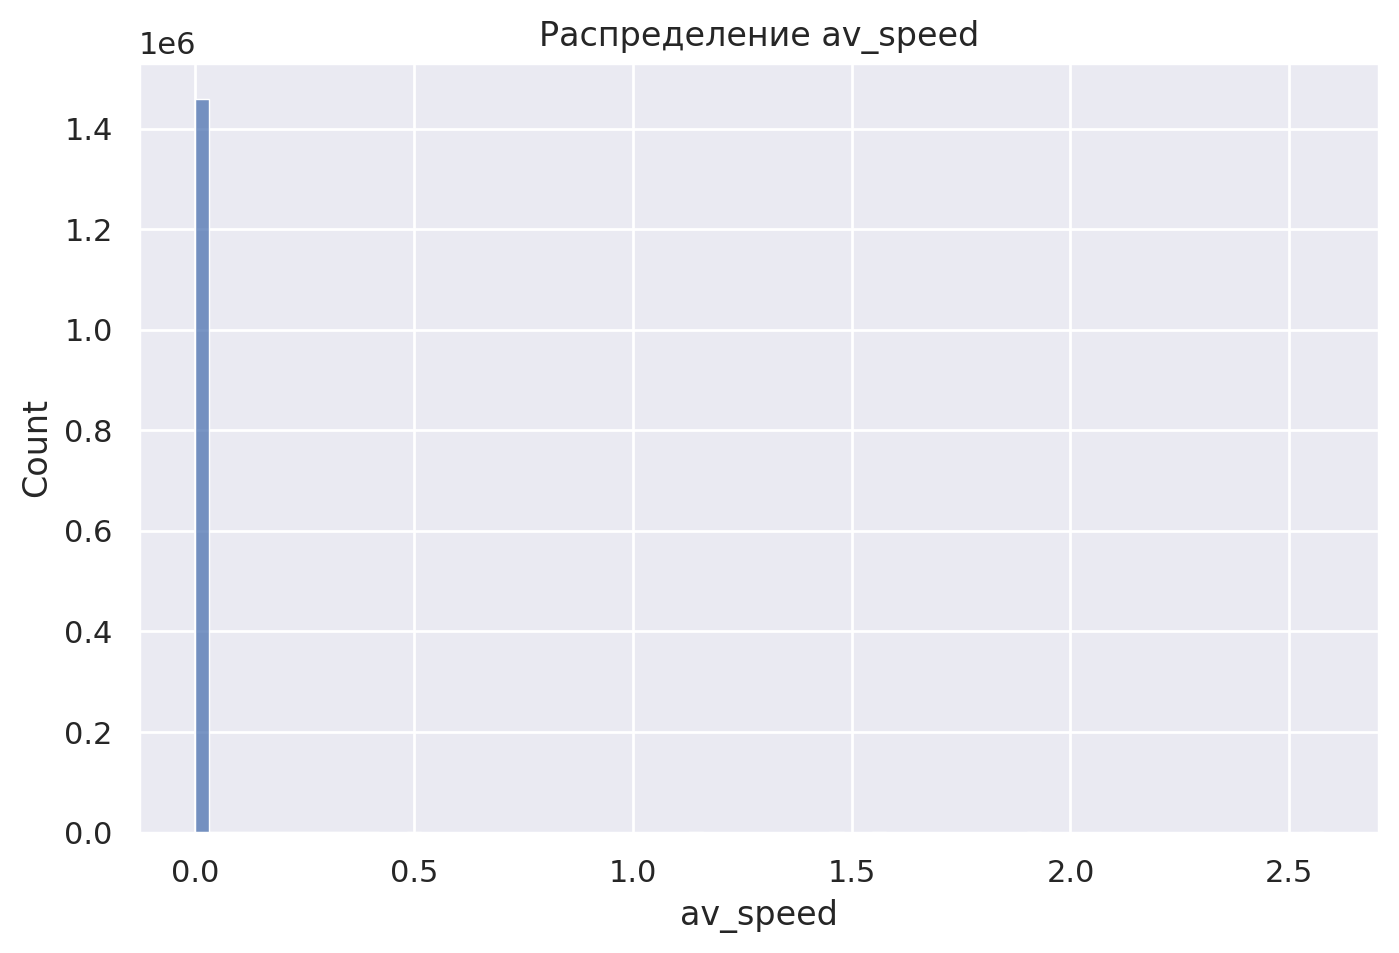

In [451]:
sns.histplot(df['av_speed'], bins=80)
plt.title('Распределение av_speed')

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

Text(0.5, 1.0, 'Распределение av_speed без больший скоростей')

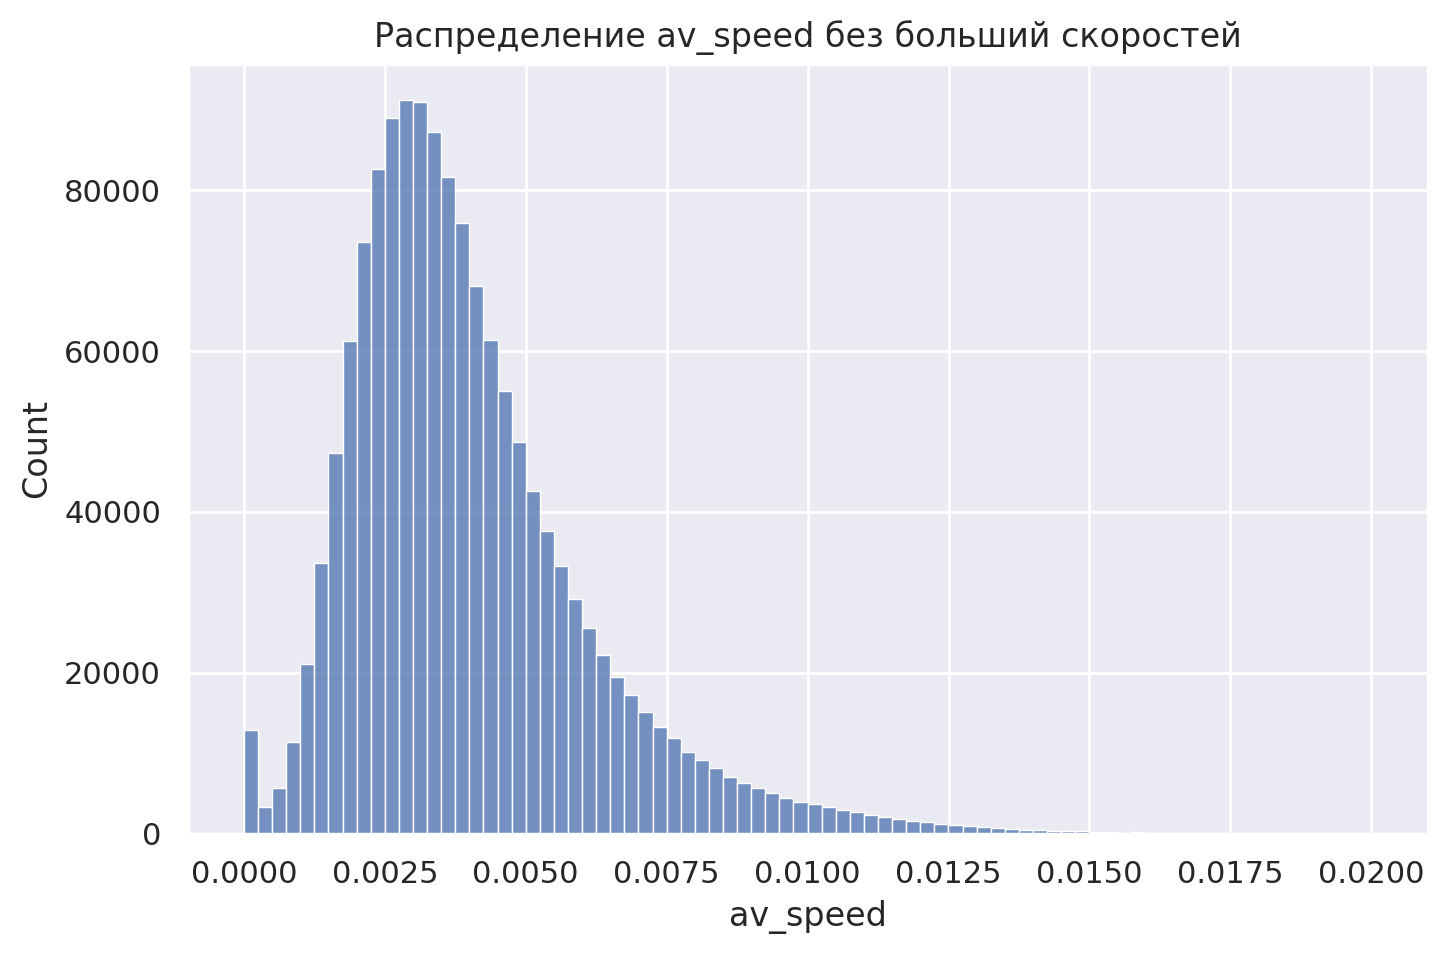

In [452]:
sns.histplot(df[df['av_speed'] < 0.02]['av_speed'], bins=80)
plt.title('Распределение av_speed без больший скоростей')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

Text(0.5, 1.0, 'Зависимость медианы скорости от времени')

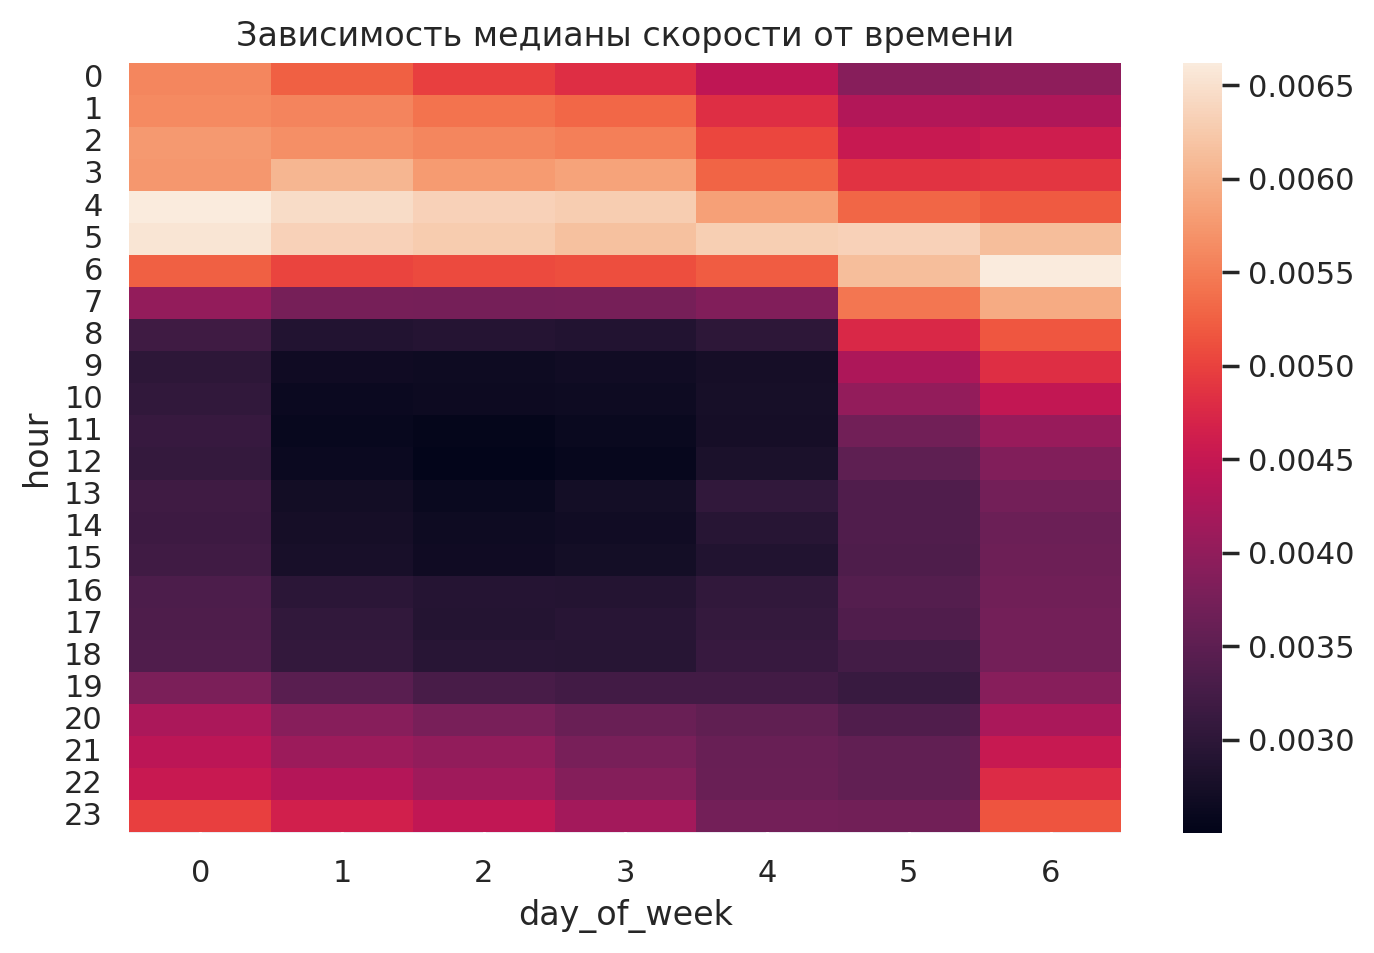

In [453]:
tmpheat = pd.pivot_table(df, index='hour', columns='day_of_week', values='av_speed', aggfunc='median')
sns.heatmap(tmpheat, annot=False)
plt.title("Зависимость медианы скорости от времени")

In [454]:
df = df.drop(columns=['av_speed'])

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

потому что значение скорости получено с использованием целевой переменной. мы не сможем ее расчитать для тестовой выборки

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Скорость минимальна со вторника по пятницу, в период с 8 до 18 часов. Скорость максимальна в 5 утра любого дня, в 6 утра выходных дней и 4 утра будних дней

In [455]:
df['traffic_jam'] = 1 * (((df['day_of_week'] >= 1) & (df['day_of_week'] <= 4) & (df['hour'] >= 8) & (df['hour'] <= 18)))
df['free_roads'] = 1 * ((df['hour'] == 5) | ((df['day_of_week'] >= 5) & (df['hour'] == 6)) | ((df['day_of_week'] <= 3) & (df['hour'] == 4)))

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

они могут быть полезны тем, что поездки от/в аэропорта/вокзала могут быть похожи между собой по времени. 

In [456]:
df['is_airport_start'] = 1 * ((df['pickup_latitude'] <= 40.79) & (df['pickup_latitude'] >= 40.76) & (df['pickup_longitude'] <= -73.86) & (df['pickup_longitude'] >= -73.88))
df['is_station_start'] = 1 * ((df['pickup_latitude'] <= 40.755) & (df['pickup_latitude'] >= 40.751) & (df['pickup_longitude'] <= -73.976) & (df['pickup_longitude'] >= -73.978))
df['is_airport_end'] = 1 * ((df['dropoff_latitude'] <= 40.79) & (df['dropoff_latitude'] >= 40.76) & (df['dropoff_longitude'] <= -73.86) & (df['dropoff_longitude'] >= -73.88))
df['is_station_end'] = 1 * ((df['dropoff_latitude'] <= 40.755) & (df['dropoff_latitude'] >= 40.751) & (df['dropoff_longitude'] <= -73.976) & (df['dropoff_longitude'] >= -73.978))

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

Text(0.5, 1.0, 'Зависимость log_trip_duration от traffic_jam')

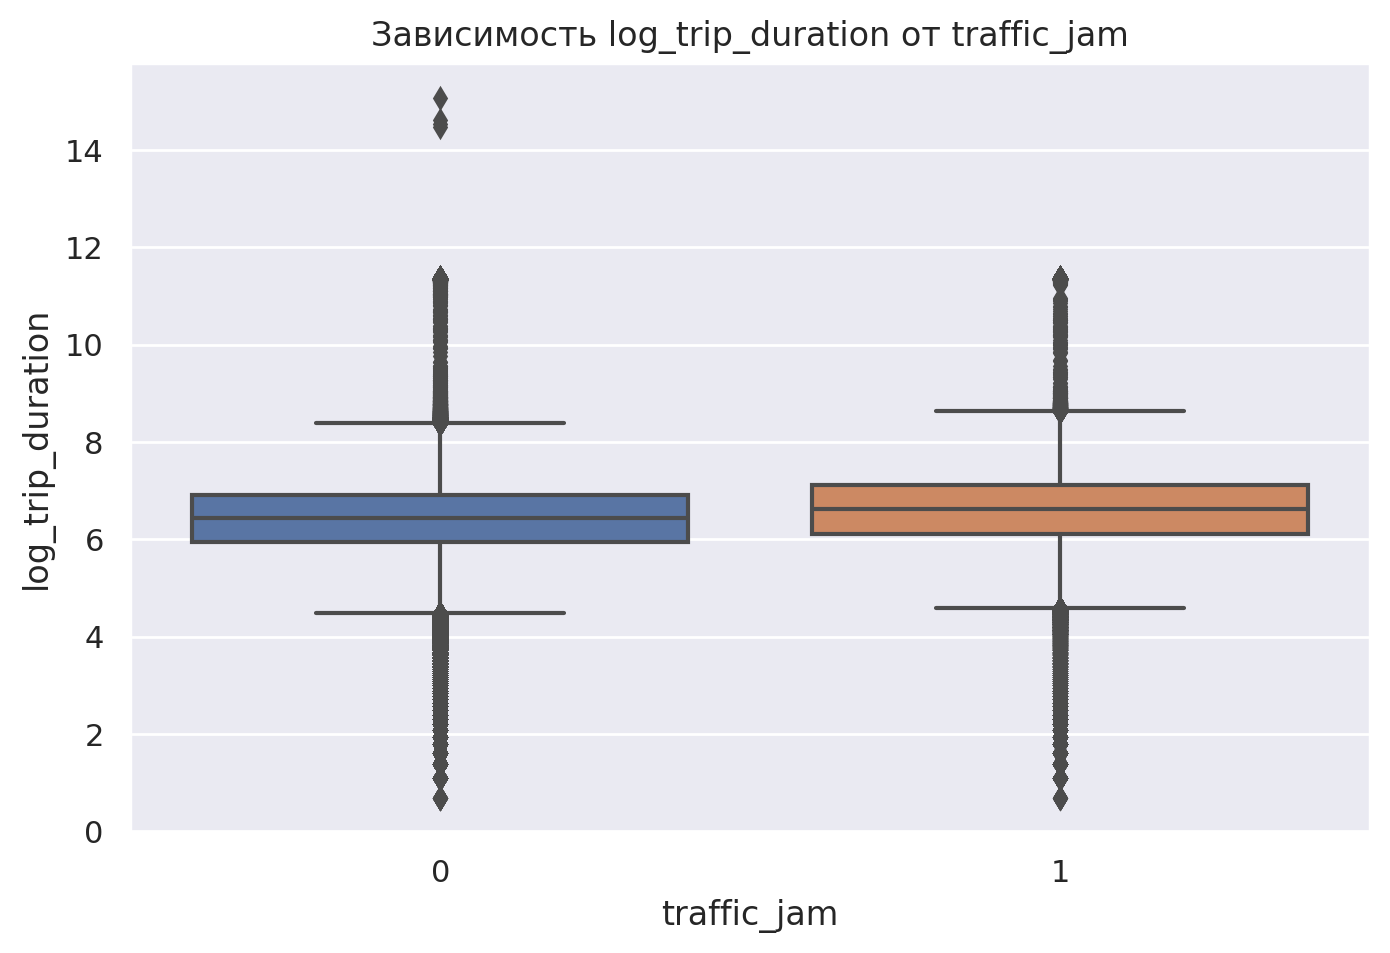

In [457]:
sns.boxplot(data=df, x='traffic_jam', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от traffic_jam")

Text(0.5, 1.0, 'Зависимость log_trip_duration от free_roads')

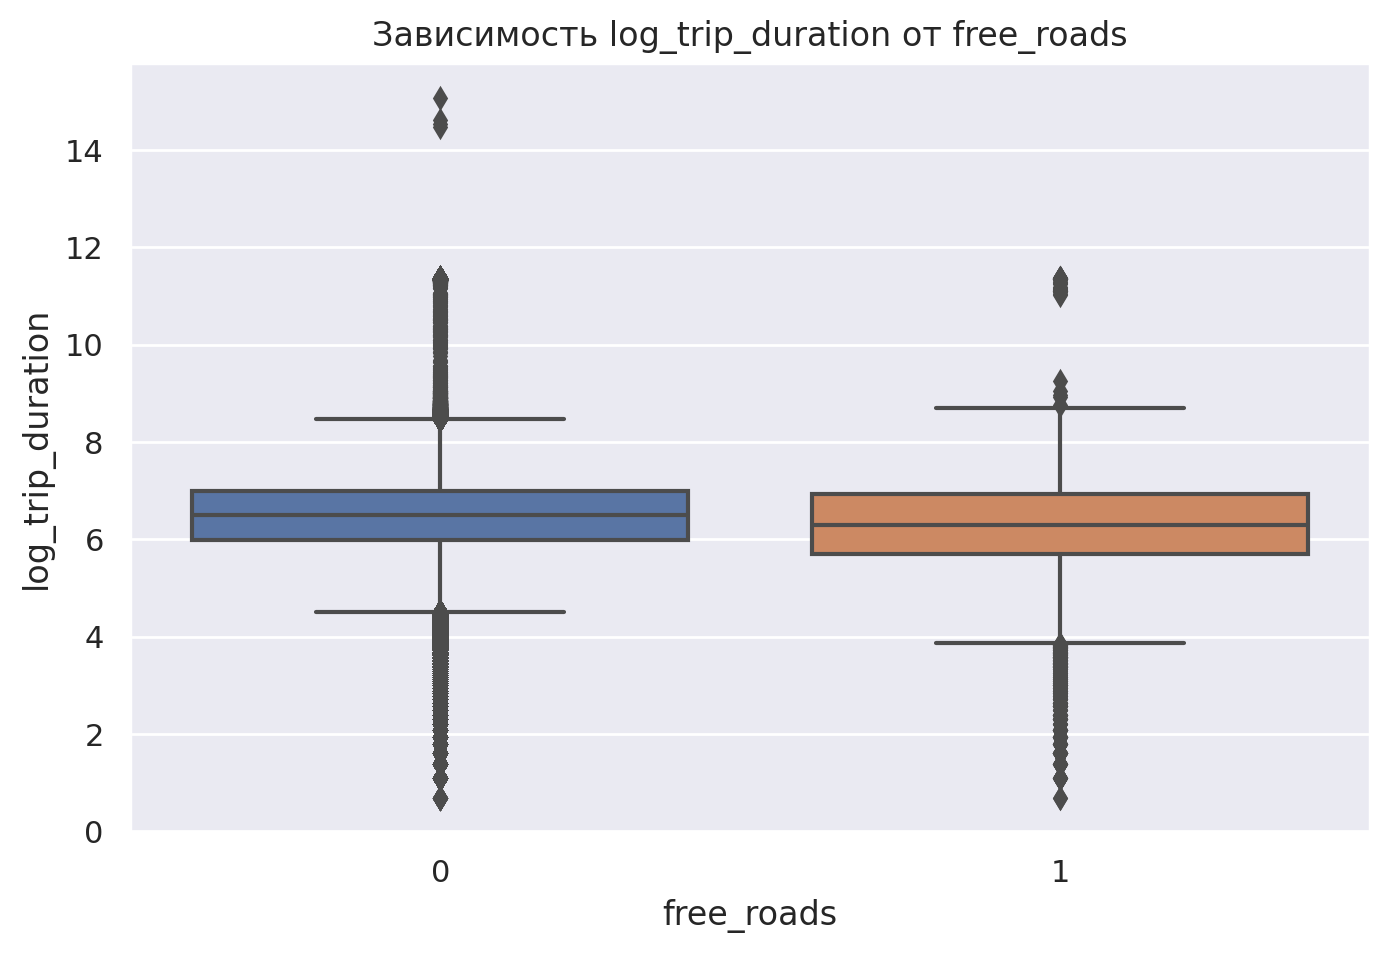

In [458]:
sns.boxplot(data=df, x='free_roads', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от free_roads")

Text(0.5, 1.0, 'Зависимость log_trip_duration от is_airport_start')

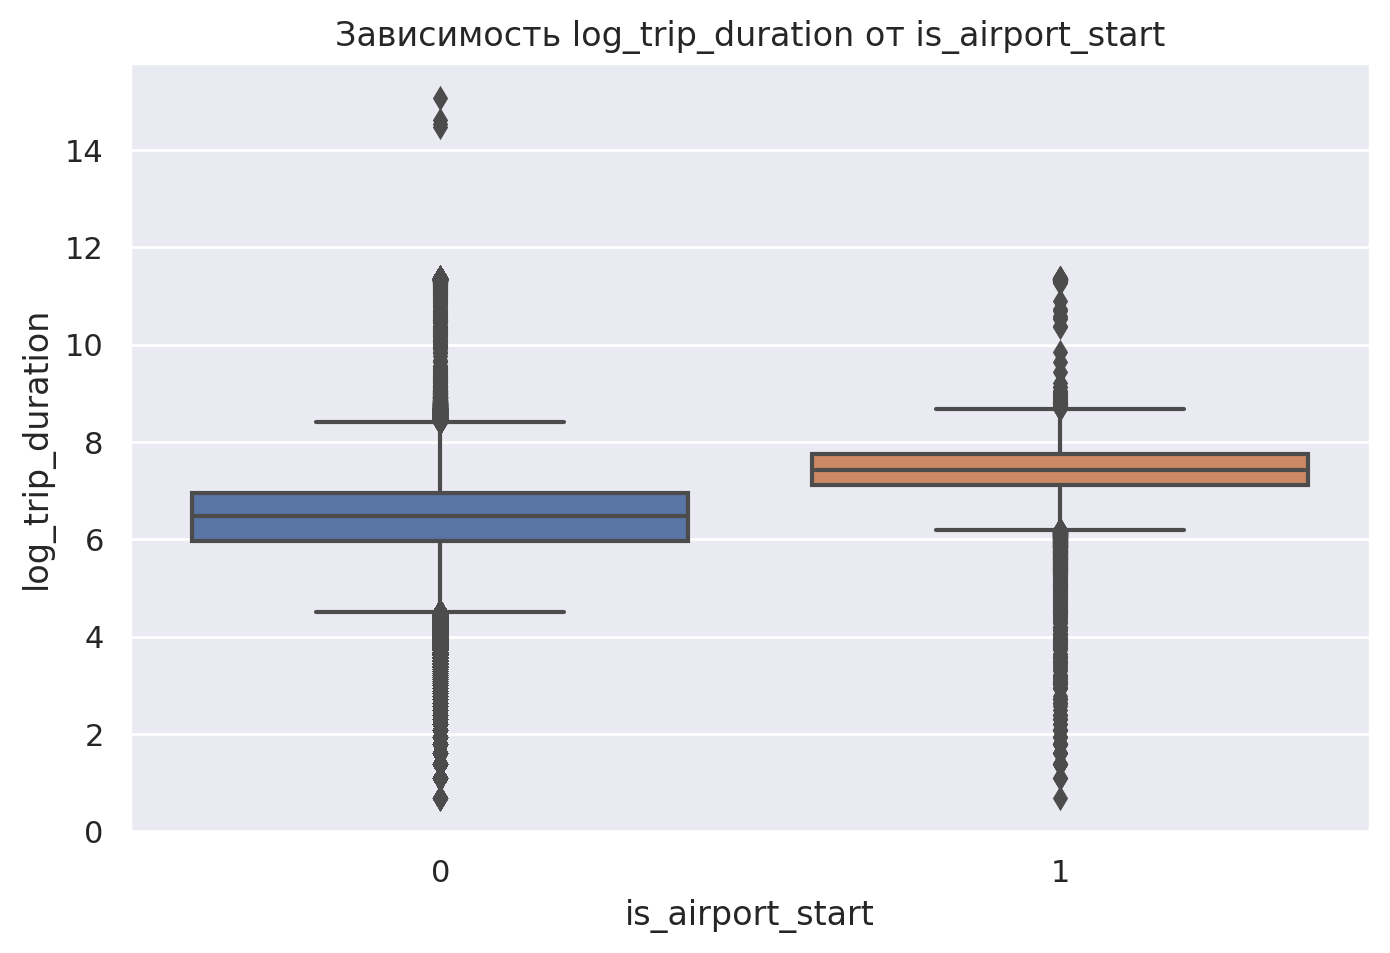

In [459]:
sns.boxplot(data=df, x='is_airport_start', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от is_airport_start")

Text(0.5, 1.0, 'Зависимость log_trip_duration от is_station_start')

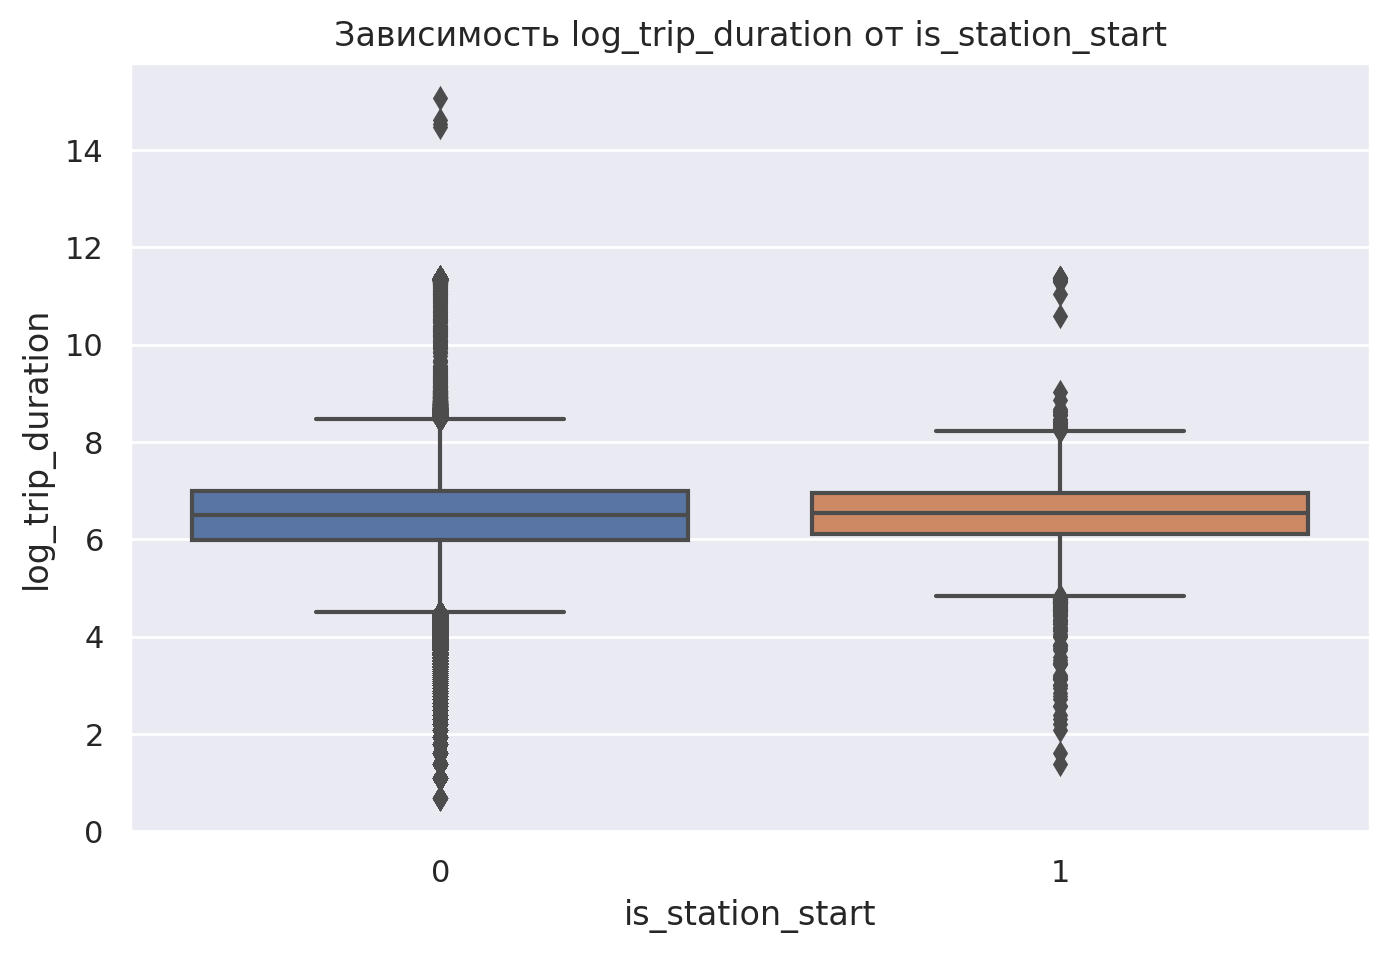

In [460]:
sns.boxplot(data=df, x='is_station_start', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от is_station_start")

Text(0.5, 1.0, 'Зависимость log_trip_duration от is_airport_end')

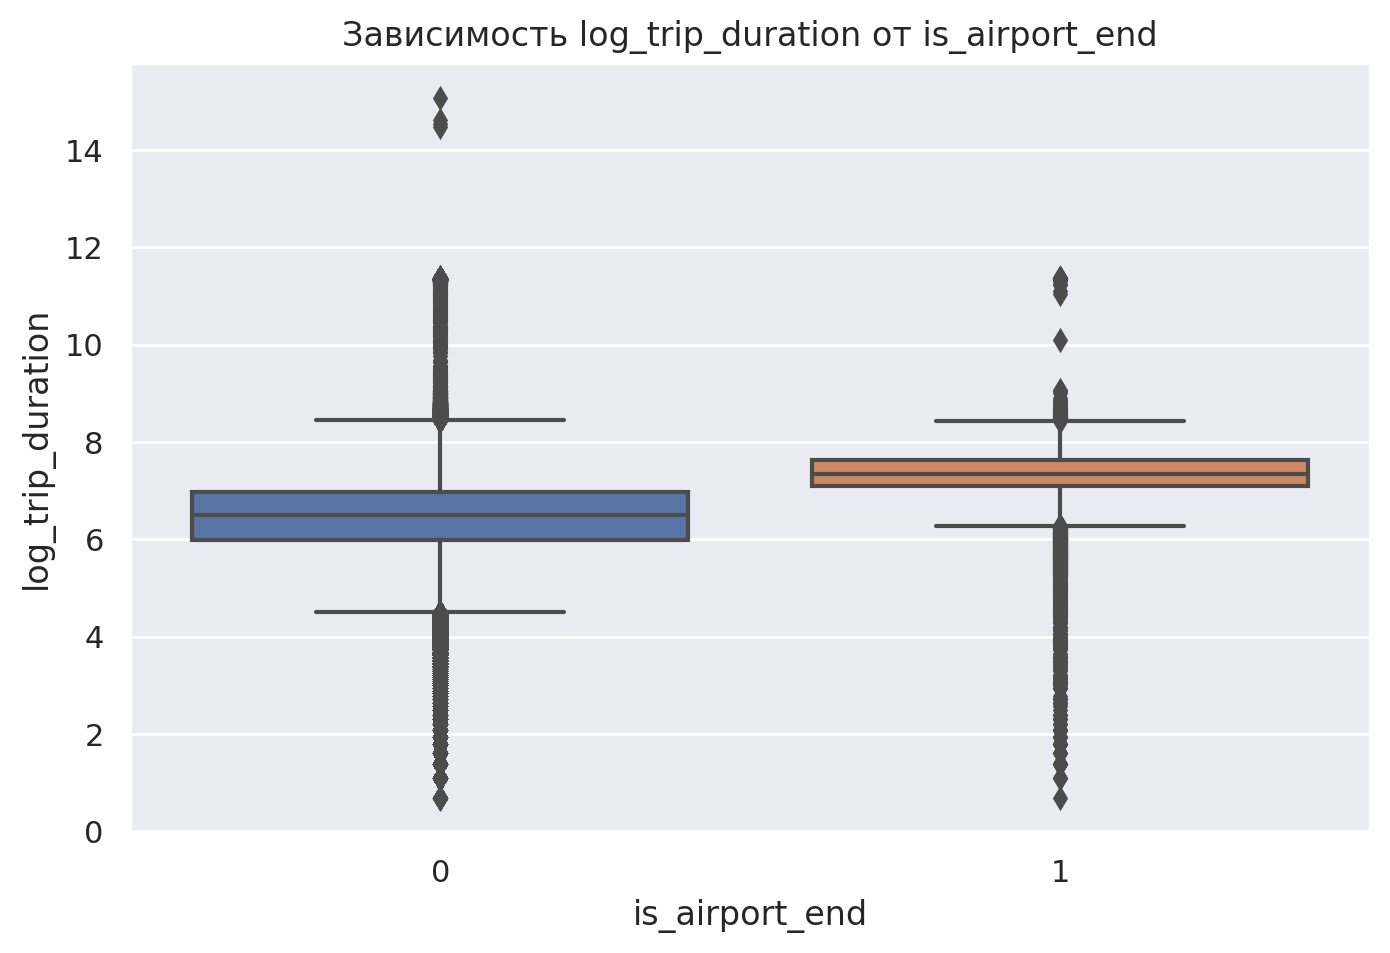

In [461]:
sns.boxplot(data=df, x='is_airport_end', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от is_airport_end")

Text(0.5, 1.0, 'Зависимость log_trip_duration от is_station_end')

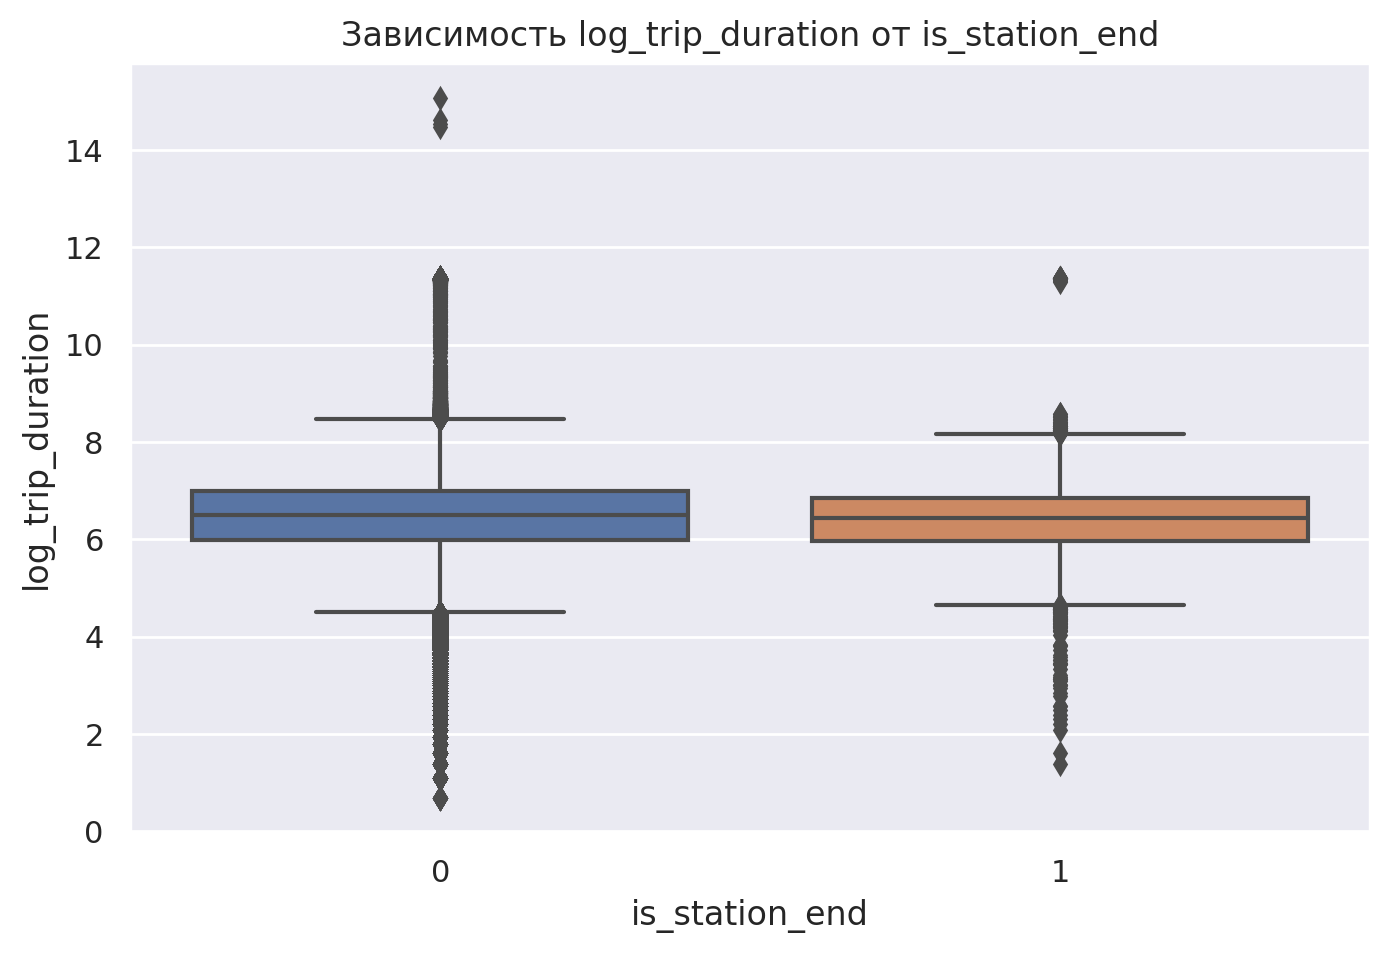

In [462]:
sns.boxplot(data=df, x='is_station_end', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от is_station_end")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Да, для каждого графика заметна разница. Для точки аэропорта это особенно выделяется.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [463]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ...):
        # your code here
        pass

    def show_map(self):
        # you may want to visualize cells
        pass

    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
        # your code here
        return X

SyntaxError: ignored

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [464]:
df_for_ridge = df[['log_trip_duration', 'day_of_week', 'month', 'hour', 'is_abnormal_1', 'is_abnormal_2', 'day_of_year', 'log_haversine', 'traffic_jam', 'free_roads', 'is_airport_start', 'is_station_start', 'is_airport_end', 'is_station_end']]

y = df_for_ridge['log_trip_duration']
x = df_for_ridge.drop(columns=['log_trip_duration'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
num_feat = ['day_of_year', 'log_haversine']
cat_feat = ['is_abnormal_1', 'is_abnormal_2', 'day_of_week', 'month', 'hour', 'traffic_jam', 'free_roads', 'is_airport_start', 'is_station_start', 'is_airport_end', 'is_station_end']

col_transf = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_feat),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4966


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

passenger_count может быть полезен тем, что при большом числе пассажиров машина едет медленнее из-за увеличенного веса \
store_and_fwd_flag может быть полезен тем, что, если данные не отправляются, возможно что-то случилось с системой и будет задержка \


In [465]:
print('уникальных vendor_id:', len(df['vendor_id'].unique()))
print('уникальных passenger_count:', len(df['passenger_count'].unique()))
print('уникальных store_and_fwd_flag:', len(df['store_and_fwd_flag'].unique()))

уникальных vendor_id: 2
уникальных passenger_count: 10
уникальных store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

Text(0.5, 1.0, 'Зависимость log_trip_duration от vendor_id')

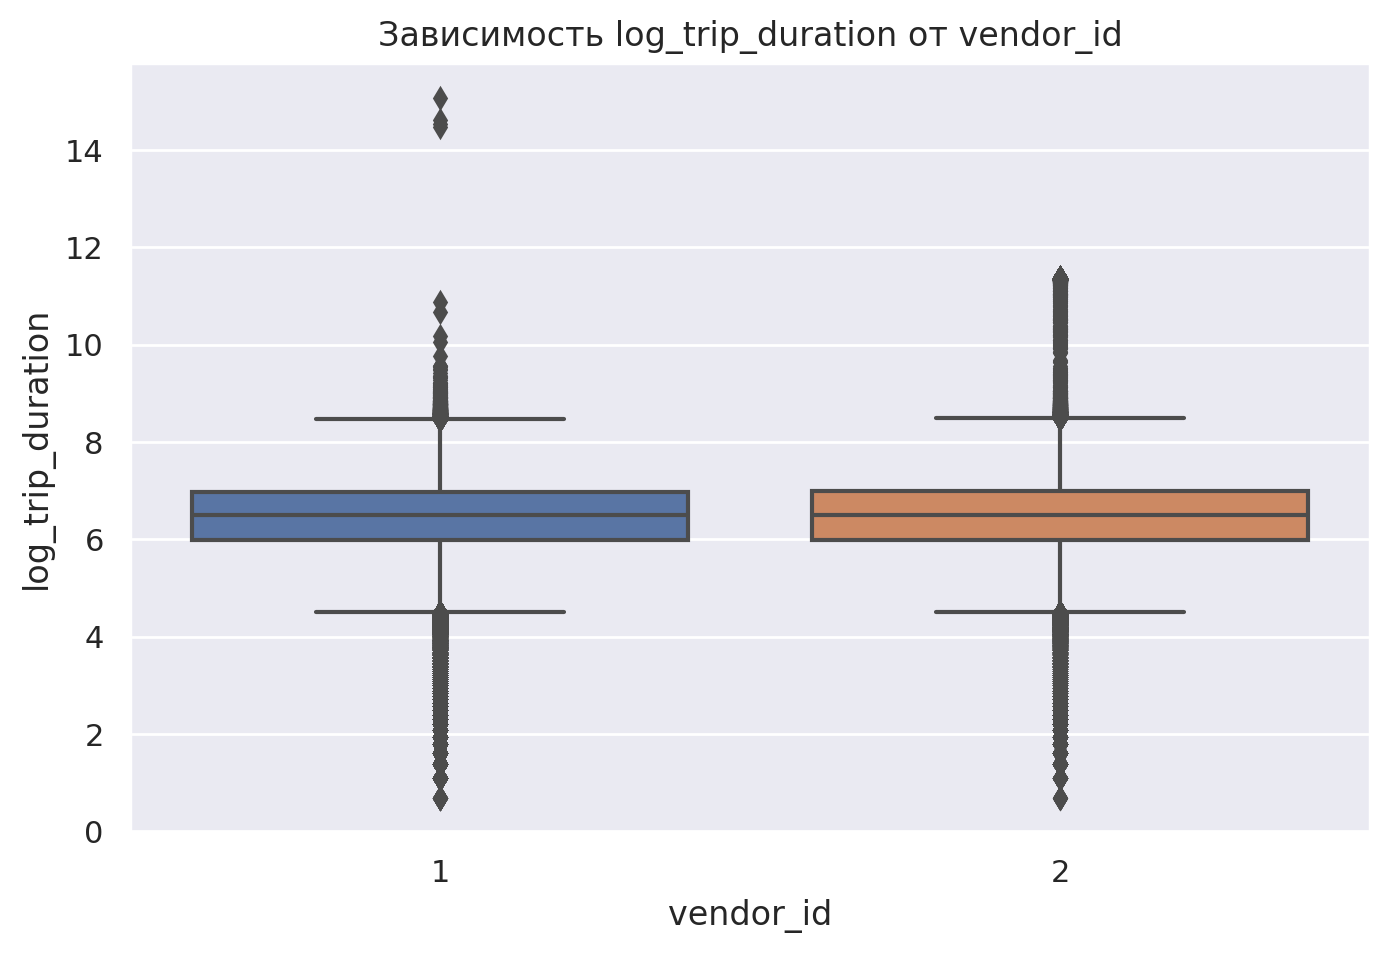

In [466]:
sns.boxplot(data=df, x='vendor_id', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от vendor_id")

Text(0.5, 1.0, 'Зависимость log_trip_duration от passenger_count')

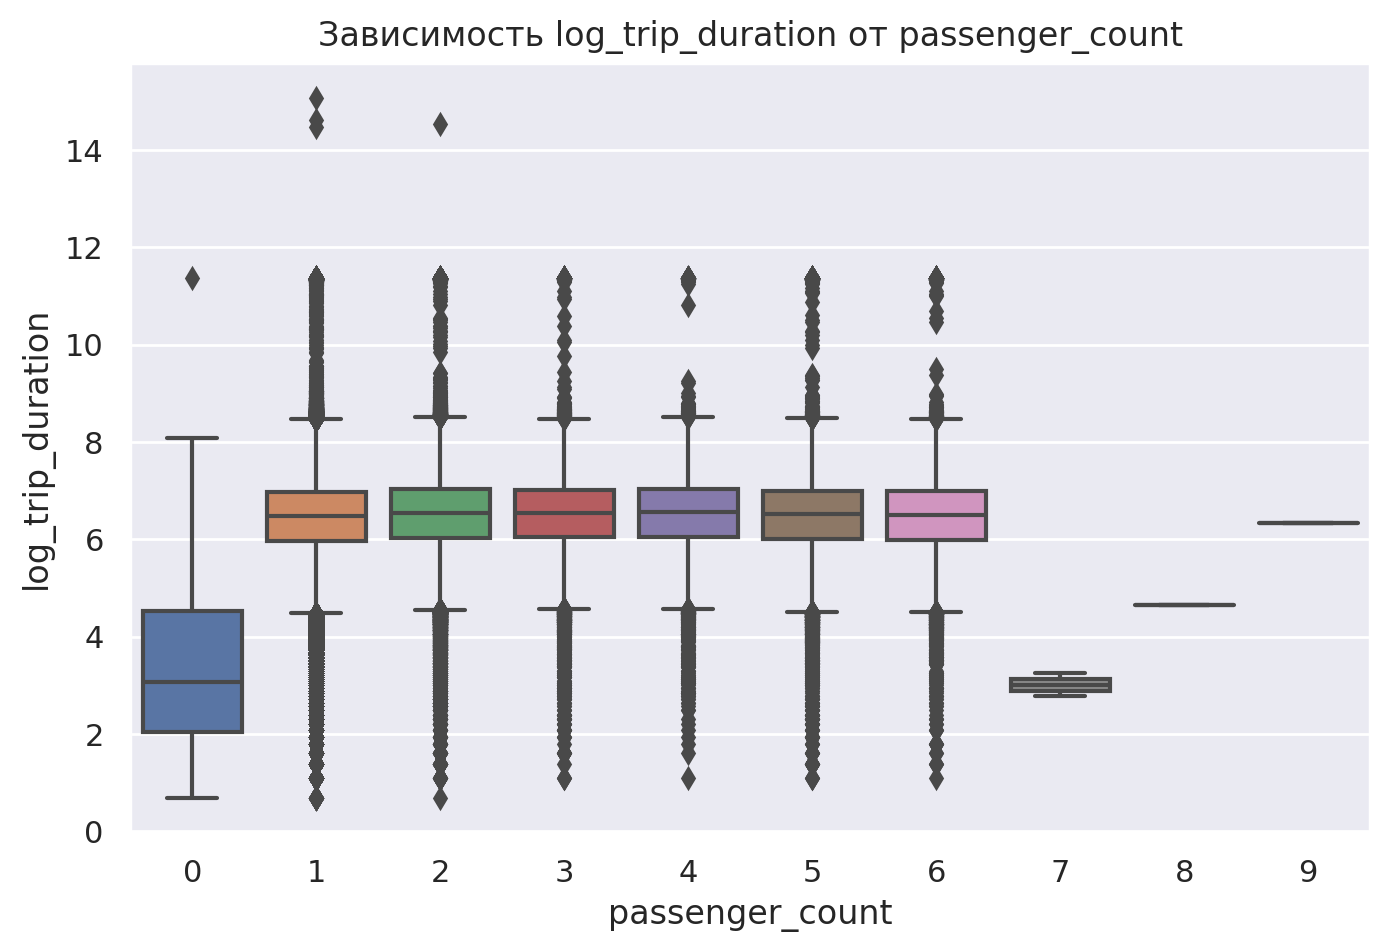

In [467]:
sns.boxplot(data=df, x='passenger_count', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от passenger_count")

Text(0.5, 1.0, 'Зависимость log_trip_duration от store_and_fwd_flag')

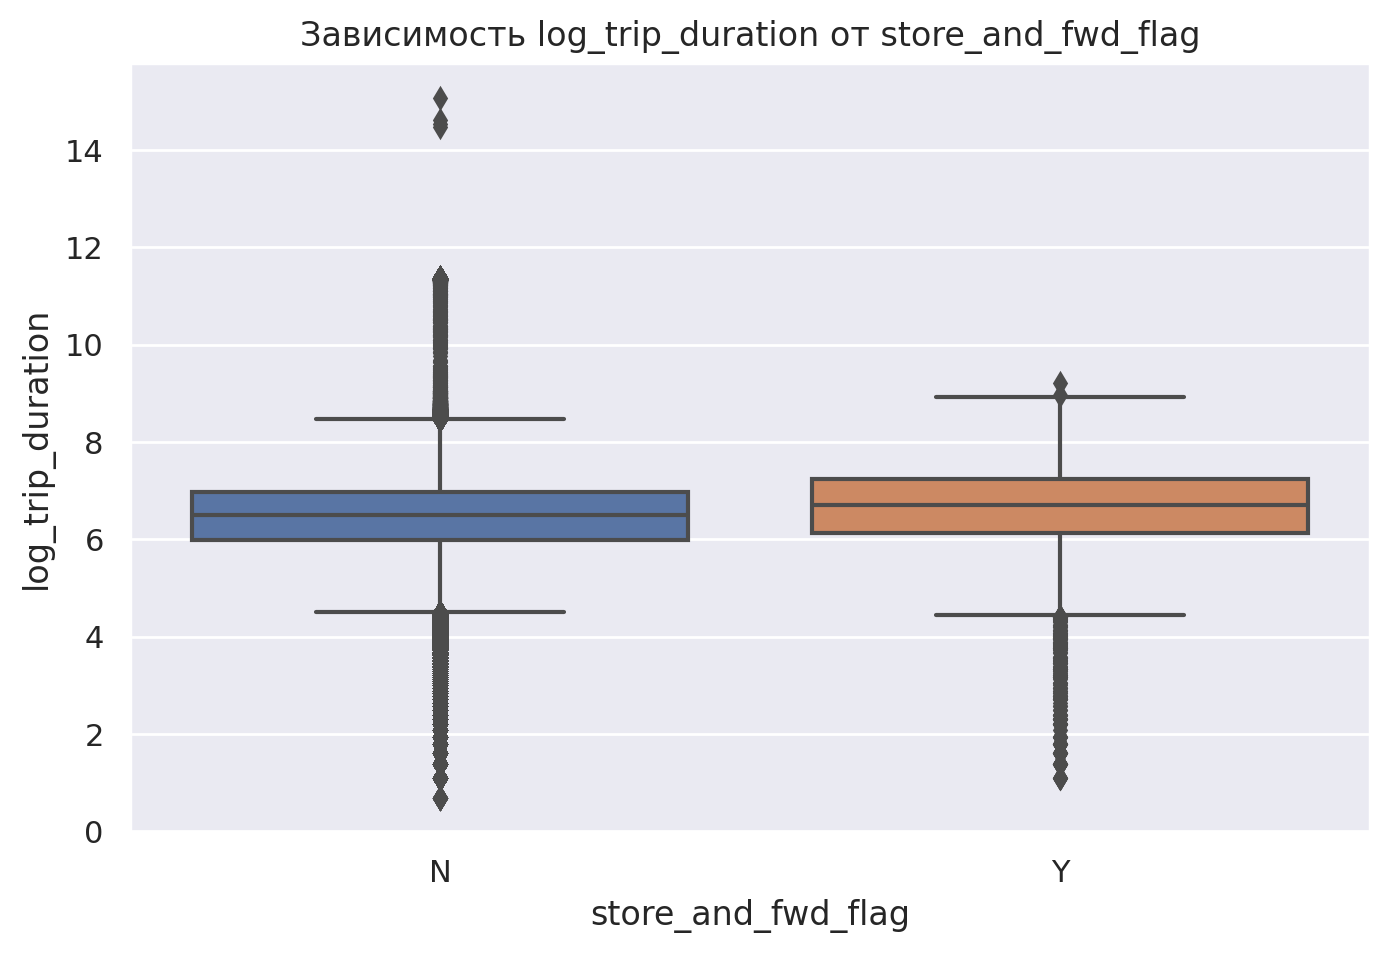

In [468]:
sns.boxplot(data=df, x='store_and_fwd_flag', y='log_trip_duration')
plt.title("Зависимость log_trip_duration от store_and_fwd_flag")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [469]:
df['vendor_id'] = df['vendor_id'] - 1
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace(['N', 'Y'], [0, 1])

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Особой разницы в графиках не видно, но для store_and_fwd_flag она заметна. Не думаю, что эти признаки будут сильными, за исключением store_and_fwd_flag.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [470]:
df_for_ridge = df[['log_trip_duration', 'day_of_week', 'month', 'hour', 'is_abnormal_1', 'is_abnormal_2', 'day_of_year', 'log_haversine', 'traffic_jam', 'free_roads', 'is_airport_start', 'is_station_start', 'is_airport_end', 'is_station_end', 'passenger_count', 'store_and_fwd_flag', 'vendor_id']]

y = df_for_ridge['log_trip_duration']
x = df_for_ridge.drop(columns=['log_trip_duration'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
num_feat = ['day_of_year', 'log_haversine', 'passenger_count']
cat_feat = ['is_abnormal_1', 'is_abnormal_2', 'day_of_week', 'month', 'hour', 'traffic_jam', 'is_airport_start', 'is_station_start', 'is_airport_end', 'is_station_end', 'free_roads', 'store_and_fwd_flag', 'vendor_id']

col_transf = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_feat),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4964


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [471]:
df_for_ridge = df_for_ridge.drop(columns=['passenger_count', 'store_and_fwd_flag', 'vendor_id'])

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [472]:
abnormal_dist = (x_train[x_train['log_haversine'] < 0.1]).index
tmp_y = pd.DataFrame()
tmp_y['log_trip_duration'] = y_train
abnormal_time = (tmp_y[tmp_y['log_trip_duration'] < 1]).index
abnormal_f = abnormal_dist.union(abnormal_time)
abnormal_f
x_train = x_train.drop(abnormal_f)
y_train = y_train.drop(abnormal_f)
y_d_regression = model.predict(x_train)
tmp_y_2 = pd.DataFrame()
tmp_y_2['d'] = y_d_regression - y_train
abnormal_d = (tmp_y_2[abs(tmp_y_2['d']) > 3]).index
x_train = x_train.drop(abnormal_d)
y_train = y_train.drop(abnormal_d)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [473]:
df[cat_feat].nunique()

is_abnormal_1          2
is_abnormal_2          2
day_of_week            7
month                  6
hour                  24
traffic_jam            2
is_airport_start       2
is_station_start       2
is_airport_end         2
is_station_end         2
free_roads             2
store_and_fwd_flag     2
vendor_id              2
dtype: int64

по всем этим признакам построены графики с примерно одинаковым распределением (то есть очень редких нет).

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [474]:
num_feat = ['day_of_year', 'log_haversine']
cat_feat = ['is_abnormal_1', 'is_abnormal_2', 'day_of_week', 'month', 'hour', 'traffic_jam', 'is_airport_start', 'is_station_start', 'is_airport_end', 'is_station_end', 'free_roads']

col_transf = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_feat),
    ('scaling', StandardScaler(), num_feat)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4967


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [475]:
print('До OneHot-кодирования:', x_train.shape[1])
print('После OneHot-кодирования:', col_transf.transform(x_train).shape[1])

До OneHot-кодирования: 16
После OneHot-кодирования: 55


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [476]:
from sklearn.linear_model import Lasso

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Lasso())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7943


Ridge-регрессия имеет меньшую ошибку, а ошибка Lasso-регрессии сравнима с лучшей константой. Ridge-регрессия лучше

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [477]:
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=10)

from sklearn.model_selection import GridSearchCV #часть кода взята из 2-го семинара

alphas = np.logspace(-3, 2, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(x_val, y_val)

best_alpha_ridge = searcher.best_params_["alpha"]

searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(x_val, y_val)

best_alpha_lasso = searcher.best_params_["alpha"]

print("Best alpha Ridge= %.4f" % best_alpha_ridge)
print("Best alpha Lasso= %.4f" % best_alpha_lasso)

Best alpha Ridge= 8.8587
Best alpha Lasso= 0.0010


In [478]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Ridge(best_alpha_ridge))
])

model_ridge = pipeline.fit(x_train_new, y_train_new)
y_pred = model_ridge.predict(x_test)
print("Ridge, Test RMSLE = %.4f" % rmsle(y_test, y_pred))

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', col_transf),
    ('regression', Lasso(best_alpha_lasso))
])

model_lasso = pipeline.fit(x_train_new, y_train_new)
y_pred = model_lasso.predict(x_test)
print("Lasso, Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Ridge, Test RMSLE = 0.4967
Lasso, Test RMSLE = 0.4984


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

у меня не получилось вставить картинку, но это был веселый смайлик

ссылка на семинары: https://github.com/esokolov/ml-course-hse/blob/master/2023-fall/seminars/sem01-pandas.ipynb; https://github.com/esokolov/ml-course-hse/blob/master/2023-fall/seminars/sem02-sklearn-linregr.ipynb